#### School Closure Visualization/ Descriptives

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
%matplotlib inline

#Read in State ID and County ID from Raw NCES Data
ids=pd.read_table("data/ccd/2009-10/sc092a.txt")[["NCESSCH","FIPST","CONUM09","LSTATE09","CONAME09"]]
ids.rename(columns={"CONUM09":"CONUM", "LSTATE09": "STATE", "CONAME09":"COUNTY"}, inplace=True)

school=pd.read_pickle("data/school_closure_clean.pkl")

merged=pd.merge(ids, school, how="right", on="NCESSCH") #Match back onto clean data

print school.shape
print merged.shape
print merged.columns
merged.head(5)

(90713, 57)
(90713, 61)
Index([u'NCESSCH', u'FIPST', u'CONUM', u'STATE', u'COUNTY', u'LEAID', u'LEANM',
       u'SCHNAM', u'LSTATE', u'LEVEL', u'TYPE', u'STATUS', u'ULOCAL', u'FTE',
       u'TITLEI', u'STITLI', u'MAGNET', u'CHARTR', u'SHARED', u'TOTFRL',
       u'MEMBER', u'WHITE', u'TOTETH', u'NEW_ENGLAND', u'MID_ATLANTIC',
       u'EAST_NORTH_CENTL', u'WEST_NORTH_CENTL', u'SOUTH_ATLANTIC',
       u'EAST_SOUTH_CENTL', u'WEST_SOUTH_CENTL', u'MOUNTAIN', u'PACIFIC',
       u'CITY', u'SUBURB', u'TOWN', u'RURAL', u'ELEM', u'MIDDLE', u'HIGH',
       u'OTHER', u'T1_ALL', u'T1_SOME', u'T1_NONE', u'PCT_MINORITY',
       u'PCT_FRL', u'ST_RATIO', u'STNAM', u'MATH_PROF', u'ELA_PROF',
       u'MATH_PROF_CLN', u'ELA_PROF_CLN', u'MATH_RANK', u'ELA_RANK',
       u'in_ranks', u'intercept', u'CLOSED10', u'CLOSED11', u'CLOSED12',
       u'CLOSED13', u'CLOSED14', u'CLOSED'],
      dtype='object')


/Users/willhuguenin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (4,5,8,17,21,24,26,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,NCESSCH,FIPST,CONUM,STATE,COUNTY,LEAID,LEANM,SCHNAM,LSTATE,LEVEL,...,MATH_RANK,ELA_RANK,in_ranks,intercept,CLOSED10,CLOSED11,CLOSED12,CLOSED13,CLOSED14,CLOSED
0,10000201876,1,1117,AL,SHELBY COUNTY,100002,ALABAMA YOUTH SERVICES,ALABAMA YOUTH SERVICES,AL,N,...,NaN,NaN,0,1,0,0,0,0,0,0
1,10000500870,1,1095,AL,MARSHALL COUNTY,100005,ALBERTVILLE CITY,ALA AVENUE MIDDLE SCH,AL,2,...,0.520302,0.574290,1,1,0,0,0,0,0,0
2,10000500871,1,1095,AL,MARSHALL COUNTY,100005,ALBERTVILLE CITY,ALBERTVILLE HIGH SCH,AL,3,...,0.850174,0.713511,1,1,0,0,0,0,0,0
3,10000500879,1,1095,AL,MARSHALL COUNTY,100005,ALBERTVILLE CITY,EVANS ELEM SCH,AL,2,...,0.650910,0.608922,1,1,0,0,0,0,0,0
4,10000500889,1,1095,AL,MARSHALL COUNTY,100005,ALBERTVILLE CITY,ALBERTVILLE ELEM SCH,AL,1,...,0.831373,0.855913,1,1,0,0,0,0,0,0


#### Create TSV File for d3 Map

In [2]:
merged["CONUM"]=pd.to_numeric(merged.CONUM, errors="coerce")
merged=merged[merged.CONUM.notnull()]
merged["CONUM"] = merged["CONUM"].astype(np.int32)

In [3]:
bycounty = merged.groupby(by="CONUM", as_index=False)[["intercept","CLOSED"]].sum()
bycounty.rename(columns={"CLOSED":"closed", "intercept": "total"}, inplace=True)

bycounty["rate"] = bycounty.closed / bycounty.total
bycounty.rename(columns={"CONUM":"id", "intercept":"total"}, inplace=True)

bycounty[["id","rate"]].to_csv("graphics/d3-map/close_rate_bycnty.tsv", sep="\t", index=False)
bycounty.head(10)

,id,total,closed,rate
0,1001,12,0,0.000000
1,1003,43,1,0.023256
2,1005,9,1,0.111111
3,1007,10,1,0.100000
4,1009,16,0,0.000000
5,1011,4,1,0.250000
6,1013,6,0,0.000000
7,1015,34,0,0.000000
8,1017,13,0,0.000000
9,1019,7,0,0.000000


#### Look at Counties with Highest School Closure Rates

In [4]:
view=merged.groupby(by=["STATE","COUNTY"], as_index=False)[["intercept","CLOSED"]].sum()
view.rename(columns={"CLOSED":"closed", "intercept": "total"}, inplace=True)
view["rate"] = view.closed / view.total
#view.head(10)
#view.total.describe()
view.sort_values(by="rate", ascending=False).head(10)

,STATE,COUNTY,total,closed,rate
2897,VA,BLAND COUNTY,4,4,1.000000
1846,NE,GREELEY COUNTY,7,7,1.000000
896,KS,CHASE COUNTY,3,3,1.000000
1581,MS,SUNFLOWER COUNTY,15,14,0.933333
953,KS,NEMAHA COUNTY,13,11,0.846154
1017,KY,CLARK COUNTY,12,10,0.833333
187,CA,ALPINE COUNTY,4,3,0.750000
3007,VA,SUSSEX COUNTY,4,3,0.750000
2290,PA,MIFFLIN COUNTY,14,10,0.714286
2902,VA,BUCKINGHAM COUNTY,6,4,0.666667


#### Look at Closure Rates by Different Categorical Features

In [5]:
print merged.columns
print float(merged.CLOSED.value_counts()[1]) / merged.shape[0]

Index([u'NCESSCH', u'FIPST', u'CONUM', u'STATE', u'COUNTY', u'LEAID', u'LEANM',
       u'SCHNAM', u'LSTATE', u'LEVEL', u'TYPE', u'STATUS', u'ULOCAL', u'FTE',
       u'TITLEI', u'STITLI', u'MAGNET', u'CHARTR', u'SHARED', u'TOTFRL',
       u'MEMBER', u'WHITE', u'TOTETH', u'NEW_ENGLAND', u'MID_ATLANTIC',
       u'EAST_NORTH_CENTL', u'WEST_NORTH_CENTL', u'SOUTH_ATLANTIC',
       u'EAST_SOUTH_CENTL', u'WEST_SOUTH_CENTL', u'MOUNTAIN', u'PACIFIC',
       u'CITY', u'SUBURB', u'TOWN', u'RURAL', u'ELEM', u'MIDDLE', u'HIGH',
       u'OTHER', u'T1_ALL', u'T1_SOME', u'T1_NONE', u'PCT_MINORITY',
       u'PCT_FRL', u'ST_RATIO', u'STNAM', u'MATH_PROF', u'ELA_PROF',
       u'MATH_PROF_CLN', u'ELA_PROF_CLN', u'MATH_RANK', u'ELA_RANK',
       u'in_ranks', u'intercept', u'CLOSED10', u'CLOSED11', u'CLOSED12',
       u'CLOSED13', u'CLOSED14', u'CLOSED'],
      dtype='object')
0.0625725627218


In [6]:
def closure_rate(variables):
    for variable in variables:
        print merged.groupby(by=variable, as_index=False)["CLOSED"].mean()

closure_rate(["MAGNET","CHARTR","SHARED"])

   MAGNET    CLOSED
0       0  0.062164
1       1  0.079314
   CHARTR    CLOSED
0       0  0.058052
1       1  0.150725
   SHARED    CLOSED
0       0  0.062479
1       1  0.073587


In [7]:
closure_rate(["NEW_ENGLAND","MID_ATLANTIC","EAST_NORTH_CENTL","WEST_NORTH_CENTL","SOUTH_ATLANTIC","EAST_SOUTH_CENTL",\
              "WEST_SOUTH_CENTL","MOUNTAIN","PACIFIC"])

   NEW_ENGLAND    CLOSED
0            0  0.062889
1            1  0.056541
   MID_ATLANTIC    CLOSED
0             0  0.061422
1             1  0.071748
   EAST_NORTH_CENTL    CLOSED
0                 0  0.056078
1                 1  0.095216
   WEST_NORTH_CENTL    CLOSED
0                 0  0.060609
1                 1  0.080562
   SOUTH_ATLANTIC    CLOSED
0               0  0.065047
1               1  0.050206
   EAST_SOUTH_CENTL    CLOSED
0                 0  0.062864
1                 1  0.057835
   WEST_SOUTH_CENTL    CLOSED
0                 0  0.064253
1                 1  0.051178
   MOUNTAIN    CLOSED
0         0  0.066312
1         1  0.045336
   PACIFIC    CLOSED
0        0  0.063654
1        1  0.038432


In [8]:
closure_rate(["CITY","SUBURB","TOWN","RURAL"])

   CITY    CLOSED
0     0  0.056325
1     1  0.080937
   SUBURB    CLOSED
0       0  0.069063
1       1  0.046055
   TOWN    CLOSED
0     0  0.061879
1     1  0.067010
   RURAL    CLOSED
0      0  0.063469
1      1  0.060744


In [9]:
closure_rate(["ELEM","MIDDLE","HIGH","OTHER"])

   ELEM    CLOSED
0     0  0.064344
1     1  0.061343
   MIDDLE    CLOSED
0       0  0.061856
1       1  0.065731
   HIGH    CLOSED
0     0  0.066159
1     1  0.046351
   OTHER    CLOSED
0      0  0.059354
1      1  0.133215


In [10]:
closure_rate(["T1_ALL","T1_SOME","T1_NONE"])

   T1_ALL    CLOSED
0       0  0.051308
1       1  0.074192
   T1_SOME    CLOSED
0        0  0.065262
1        1  0.052664
   T1_NONE    CLOSED
0        0  0.067535
1        1  0.050291


#### Paired Bar Graph of Continuous Characteristics by Open vs. Closed

In [11]:
def by_closure(variables):
    for variable in variables:
        print merged.groupby(by="CLOSED", as_index=False)[variable].mean()

by_closure(["MEMBER","PCT_MINORITY","PCT_FRL", "ST_RATIO","MATH_RANK","ELA_RANK"])

   CLOSED      MEMBER
0       0  537.004273
1       1  283.988244
   CLOSED  PCT_MINORITY
0       0      0.419009
1       1      0.505188
   CLOSED   PCT_FRL
0       0  0.494527
1       1  0.626701
   CLOSED   ST_RATIO
0       0  15.809348
1       1  14.745437
   CLOSED  MATH_RANK
0       0   0.518412
1       1   0.414847
   CLOSED  ELA_RANK
0       0  0.516018
1       1  0.405709


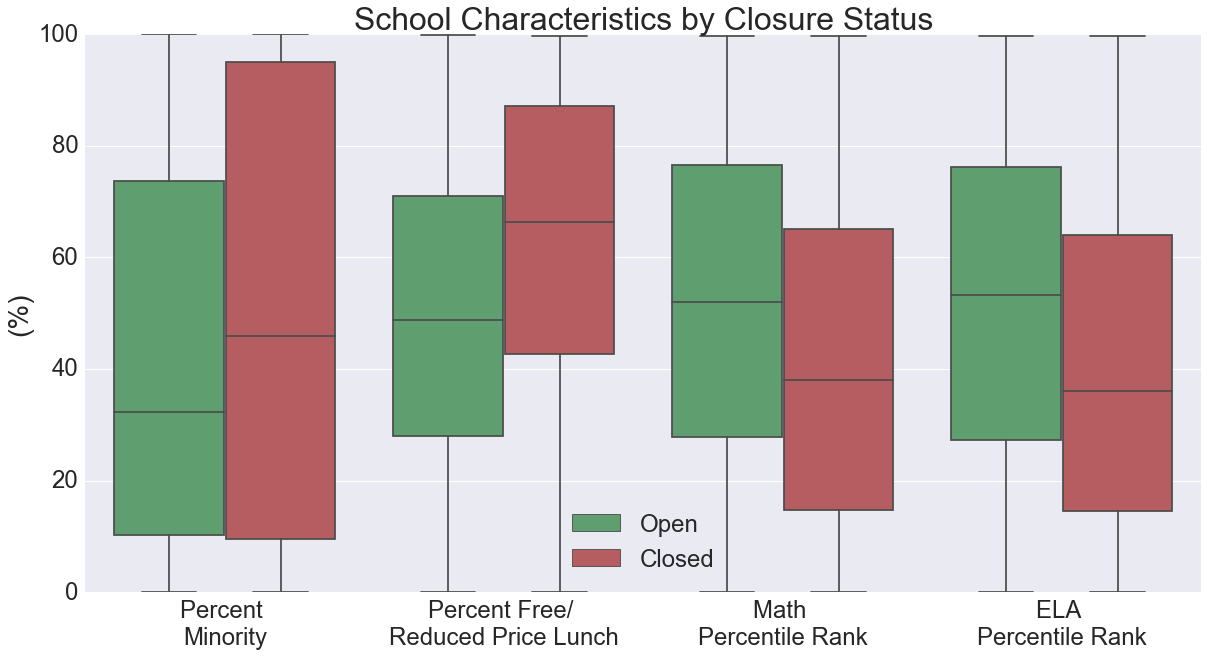

In [12]:
def graph_by_closure(df, variables):
    new_df=pd.DataFrame()
    
    for variable in variables:
        temp_df=pd.DataFrame({"var":variable, "closed": df["CLOSED"], "value": df[variable].apply(lambda x: x*100)})
        
        new_df=pd.concat([new_df, temp_df], axis=0)

    new_df["closed_txt"]="Open"
    new_df.ix[new_df.closed==1, "closed_txt"]="Closed"
      
    return sns.boxplot(x="var", y="value", hue="closed_txt", data=new_df, palette=[green, red])


plt.figure(figsize=(20,10))
green = sns.color_palette("deep")[1]
red = sns.color_palette("deep")[2]

fig = graph_by_closure(merged, ["PCT_MINORITY","PCT_FRL","MATH_RANK","ELA_RANK"])
plt.legend(loc="best", fontsize=24)

plt.xlabel(" ")
plt.ylabel("(%)", fontsize=28)
fig.set_xticklabels(["Percent \nMinority","Percent Free/ \nReduced Price Lunch",\
                     "Math \nPercentile Rank","ELA \nPercentile Rank"])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title("School Characteristics by Closure Status", fontsize=32)
plt.savefig("graphics/school-char-by-closure.png")